In [1]:
import warnings;
warnings.filterwarnings('ignore');
import pandas as pd

# Splice site prediction

Gene splicing is a post-transcriptional modification in which a single gene can code for multiple proteins. Gene Splicing is done in eukaryotes, prior to mRNA translation, by the differential inclusion or exclusion of regions of pre-mRNA. Gene splicing is an important source of protein diversity.

The vast majority of splice sites are characterized by the presence of specific dimers on the intronic side of the splice site: "GT" for donor and "AG" for acceptor sites. In this project you will fit a classification model for acceptor splice site prediction in DNA sequences.

This model will consider each AG in the DNA as a candidate acceptor site, extract a local context surrounding the candidate acceptor site, represent the candidate site as a feature vector and the predict the class ('acceptor site' or 'not acceptor site') by applying the model in the constructed feature vector.

This what the training data looks like:

In [2]:
data_train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/practicum/Classification/acceptor_sites_dataset_train.csv")

In [3]:
data_train.head(5)

,label,sequence
0,1,TTTGAATTGTAGGTGTCCTGCT
1,1,TATTTTTTAAAGAACTGGAAGA
2,1,TTTCTTTTTCAGATGAAGAATG
3,1,TATTAATTTCAGTTTGGTTGTT
4,1,TAAAAATTTAAGTTCGTCCCGA


In [4]:
data_train.shape

(1648, 2)

There are just two columns. 

The column "sequence" contains the local context DNA sequence. We can see that nucleotide positions 11 and 12 in the sequence are always "A" and "G". These are the candidate acceptor sites with a local context that consists of 10 nucleotides upstream en 10 nucleotides downstream the AG. 

The column "label" contains the class of the candidate acceptor site: 1 for "acceptor site" and -1 for "not acceptor site". 

*How many sequences does the dataset contain for each class?*

In [5]:
###Start code here

acceptor = (data_train['label']==1).value_counts()[1]
not_acceptor = (data_train['label']==1).value_counts()[0]
print("The dataset contains "+ str(acceptor) + " acceptor sites and " + str(not_acceptor) + " non acceptor sites.")

###End code here

The dataset contains 145 acceptor sites and 1503 non acceptor sites.


Next, we load the test data:

In [6]:
data_test = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/practicum/Classification/acceptor_sites_dataset_test.csv")

In [7]:
data_test

,label,sequence
0,1,TATTTTTTTCAGCCAGCAGCAG
1,1,AAACGTTTTCAGACGAGATAGT
2,1,TGAAGTTTTCAGACAAGATGAT
3,1,GCTTTACATTAGGTCCAATGGG
4,1,AAAAATTTACAGTCGGAATGCA
...,...,...
547,-1,TTTGAAGTTTAGCTTCCTTCTC
548,-1,CTGCTAATATAGTGACAGCAAT
549,-1,TTCCAAATATAGGAAAATCGAA
550,-1,AAAATGTCGCAGAACAACAAGA


To compute features from the `column` we first concatenate the training and testing data into one DataFrame. In this manner the training and testing data are processed in exactly the same way. We can later reconstruct the training and testing DataFrames.

*Use the Pandas function `concat()` to concatenate the training and testing data into a DataFrame called `data`. The training dat should be the first rows, with the testing data beneath those rows:*

In [8]:
###Start code here
data = pd.concat([data_train, data_test], ignore_index=True)
###End code here

data

,label,sequence
0,1,TTTGAATTGTAGGTGTCCTGCT
1,1,TATTTTTTAAAGAACTGGAAGA
2,1,TTTCTTTTTCAGATGAAGAATG
3,1,TATTAATTTCAGTTTGGTTGTT
4,1,TAAAAATTTAAGTTCGTCCCGA
...,...,...
2195,-1,TTTGAAGTTTAGCTTCCTTCTC
2196,-1,CTGCTAATATAGTGACAGCAAT
2197,-1,TTCCAAATATAGGAAAATCGAA
2198,-1,AAAATGTCGCAGAACAACAAGA


Pop the `label` column from the `data` DataFrame and assigned it to variable `y`:

In [9]:
###Start code here
y = data['label']
###End code here

y

0       1
1       1
2       1
3       1
4       1
       ..
2195   -1
2196   -1
2197   -1
2198   -1
2199   -1
Name: label, Length: 2200, dtype: int64

We need to represent the local context DNA sequence as a feature vector suitable for model fitting. This process is known as **feature engineering**. 

The "AG" dinucleotide in the middle of each local context sequence is the same for both classes, i.e. it does not provide any discriminative information. So, there is not rational behind computing features from this part of the local context sequence.

*Use the Pandas DataFrame `.apply()` method to remove the middle "AG" dinucleotides in the DNA sequences (don't create a new column):*

In [10]:
print(data.head())

###Start code here

data["sequence"] = data["sequence"].str.slice(stop=10) + data["sequence"].str.slice(start=12)

###End code here

print(data.head())

   label                sequence
0      1  TTTGAATTGTAGGTGTCCTGCT
1      1  TATTTTTTAAAGAACTGGAAGA
2      1  TTTCTTTTTCAGATGAAGAATG
3      1  TATTAATTTCAGTTTGGTTGTT
4      1  TAAAAATTTAAGTTCGTCCCGA
   label              sequence
0      1  TTTGAATTGTGTGTCCTGCT
1      1  TATTTTTTAAAACTGGAAGA
2      1  TTTCTTTTTCATGAAGAATG
3      1  TATTAATTTCTTTGGTTGTT
4      1  TAAAAATTTATTCGTCCCGA


First, we create a feature for each of the nucleotide positions in the local context DNA sequence.

The [pandas.Series.str.split](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html) function splits a string in a column (pandas.Series) from the beginning, at the specified delimiter string.

*Use this function to split the `sequence` column into one column for each nucleotide positon. Put the resulting columns in a DataFrame called `data_features`:*

In [11]:
###Start code here
data_features = data["sequence"].str.split("", expand=True).iloc[:,1:21]
###End code here

data_features

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,T,T,T,G,A,A,T,T,G,T,G,T,G,T,C,C,T,G,C,T
1,T,A,T,T,T,T,T,T,A,A,A,A,C,T,G,G,A,A,G,A
2,T,T,T,C,T,T,T,T,T,C,A,T,G,A,A,G,A,A,T,G
3,T,A,T,T,A,A,T,T,T,C,T,T,T,G,G,T,T,G,T,T
4,T,A,A,A,A,A,T,T,T,A,T,T,C,G,T,C,C,C,G,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,T,T,T,G,A,A,G,T,T,T,C,T,T,C,C,T,T,C,T,C
2196,C,T,G,C,T,A,A,T,A,T,T,G,A,C,A,G,C,A,A,T
2197,T,T,C,C,A,A,A,T,A,T,G,A,A,A,A,T,C,G,A,A
2198,A,A,A,A,T,G,T,C,G,C,A,A,C,A,A,C,A,A,G,A


In a Pandas DataFrame, the `.columns` attirbute contains a list with the column names.

*Rename the columns to the relative position of the nucleotide position in the local context (from -10 to 10):*

In [12]:
###Start code here
data_features.columns = list(range(-10,0,1)) + list(range(1,11,1))
###End code here

data_features

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
0,T,T,T,G,A,A,T,T,G,T,G,T,G,T,C,C,T,G,C,T
1,T,A,T,T,T,T,T,T,A,A,A,A,C,T,G,G,A,A,G,A
2,T,T,T,C,T,T,T,T,T,C,A,T,G,A,A,G,A,A,T,G
3,T,A,T,T,A,A,T,T,T,C,T,T,T,G,G,T,T,G,T,T
4,T,A,A,A,A,A,T,T,T,A,T,T,C,G,T,C,C,C,G,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,T,T,T,G,A,A,G,T,T,T,C,T,T,C,C,T,T,C,T,C
2196,C,T,G,C,T,A,A,T,A,T,T,G,A,C,A,G,C,A,A,T
2197,T,T,C,C,A,A,A,T,A,T,G,A,A,A,A,T,C,G,A,A
2198,A,A,A,A,T,G,T,C,G,C,A,A,C,A,A,C,A,A,G,A


Next we apply `sklearn.preprocessing.LabelEncoder` to repace each nucleotide by a number.

*Create a Pandas DataFrame `data_features_int_encoding` by applying the `LabelEncoder` on each feature in `data_features`:*

In [13]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

data_features_int_encoding = pd.DataFrame()
for col in data_features.columns:
    ###Start code here
    data_features_int_encoding[col] = labelencoder.fit_transform(data_features[col].values.flatten())
    ###End code here
    
data_features_int_encoding.head()

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
0,3,3,3,2,0,0,3,3,2,3,2,3,2,3,1,1,3,2,1,3
1,3,0,3,3,3,3,3,3,0,0,0,0,1,3,2,2,0,0,2,0
2,3,3,3,1,3,3,3,3,3,1,0,3,2,0,0,2,0,0,3,2
3,3,0,3,3,0,0,3,3,3,1,3,3,3,2,2,3,3,2,3,3
4,3,0,0,0,0,0,3,3,3,0,3,3,1,2,3,1,1,1,2,0


Finally, we recontruct the training and testing data DataFrames based on the number of datapoints in the training data:

In [14]:
data_features_int_encoding_train = data_features_int_encoding.iloc[:len(data_train),:]
data_features_int_encoding_test = data_features_int_encoding.iloc[len(data_train):,:]

y_train = y.iloc[:len(data_train)]
y_test = y.iloc[len(data_train):]

Now we evaluate the generalization performance of a logistic regression model with hyperparameters $C=0.1$ on the dataset `data_features_int_encoding` using 10-fold cross-validation. 

*Apply the `cross_val_score()` function to compute an accuracy score for each fold in the CV:*

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

###Start code here
model = LogisticRegression(C=0.1)
scores = cross_val_score(model, data_features_int_encoding_train, y_train, cv=10)
###Start code here

print(np.mean(scores))

0.9253658536585366


*Fit a logistic regression model on the train set.*

In [16]:
###Start code here

LogReg = model.fit(data_features_int_encoding_train, y_train)

###End code here

*Make predictions for the test set.*

In [17]:
###Start code here
predictions = model.predict(data_features_int_encoding_test)
###End code here

Scikit-learn offers many metrics to evaluate model predictions. These functions are contained in the `metrics` module of `sklearn`. 

*Can you find how to compute the accuracy of these predictions (use the `metrics`module)?*

In [18]:
from sklearn import metrics

###Start code here
score_acc = metrics.accuracy_score(y_test, predictions)
###End code here

print(score_acc)

0.9221014492753623


An accuracy above 90% seems like a good score. But is it? Let's consider a model that predicts class "-1" for all test points.

In [19]:
predictions_zero = [-1]*len(data_test.label)

*What is the accuracy of these predictions?*

In [20]:
###Start code here
score_acc = metrics.accuracy_score(y_test, predictions_zero)
###End code here

print(score_acc)

0.9003623188405797


So this should be a good score as well, even though we did not learn anything.

For classification tasks where the classes are highly imbalanced, accuracy is not a good metric to evaluate the generalization performance. In fact, if there are 0.1% "AG" dinucleotides in a genome that are true acceptor sites then a model that predicts class "-1" for each "AG" would have an accuracy of 99.9%.

We have seen how a ROC curve plots the true positives rate against the false positives rate. Both these metrics focus on the positive class, in our case the true acceptor sites. These metrics are much more suitable to evalute the performance of models on tasks with highly imbalanced classes. To transform a ROC curve into one metric we can use the area under the curve (AUC). 

*What is the AUC score of the predictions computed by the linear regression model we fitted?*

In [21]:
###Start code here
score_auc = metrics.roc_auc_score(y_test, predictions)
###End code here

print(score_auc)

0.6737698920797514


To compute the AUC, we actually need the predictions to be scores (a continuous value) rather than class labels (discrete values).

For logistic regression these scores are the class probabilities predicted by the model (a value between 0 and 1). 

We can obtain these scores with the `predict_proba()` function of the `LogisticRegression` module as follows:

In [22]:
predictions = model.predict_proba(data_features_int_encoding_test)

print(predictions)

[[0.33015439 0.66984561]
 [0.44977258 0.55022742]
 [0.34876393 0.65123607]
 ...
 [0.99674001 0.00325999]
 [0.9820754  0.0179246 ]
 [0.982688   0.017312  ]]


The first and second column contain the predicted probabilities for class '-1' and '1' respectively. To compute the AUC we need to use the positive class probabilities. 

*What is the AUC now?*

In [23]:
###Start code here
score_auc = metrics.roc_auc_score(y_test, predictions[:,1])
###End code here

print(score_auc)

0.8841046277665996


Is this good generalization performance?

Transforming categorical features into ordered integers is maybe not a good idea as the nucleotides don't have any ordering (the columns are not ordinal features). 

It is better to transform a categorical feature into one binary feature for each category (known as *one-hot* encoding). 

*Use the Pandas function `get_dummies()` to compute one-hot encoded features (put them in a DataFrame called `data_features_onehot_encoding`:*

In [24]:
###Start code here
data_features_onehot_encoding = pd.get_dummies(data_features)
###End code here

data_features_onehot_encoding

,-10_A,-10_C,-10_G,-10_T,-9_A,-9_C,-9_G,-9_T,-8_A,-8_C,...,8_G,8_T,9_A,9_C,9_G,9_T,10_A,10_C,10_G,10_T
0,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
2196,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2197,0,0,0,1,0,0,0,1,0,1,...,1,0,1,0,0,0,1,0,0,0
2198,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0


Evaluate the generalization performance of a logisitc regression model with hyperparameters $C=1$ on the training data in `data_features_onehot_encoding` using 10-fold cross-validation. 

The `cross_val_score()` has a function parameter called `scoring` that allows you to set different scoring metrics.

*Use the `cross_val_score()` function to compute the mean AUC of the CV-scores.* 


In [25]:
model = LogisticRegression(C=1)

###Start code here
data_features_onehot_encoding_train = data_features_onehot_encoding.iloc[:len(data_train),:]
y_onehot_encoding_train = y.iloc[:len(data_train)]

score_auc = np.mean(cross_val_score(model, data_features_onehot_encoding_train, y_onehot_encoding_train, cv=10, scoring='roc_auc'))
###End code here

print(score_auc)

0.9847463891516872


*What is the AUC on `data_test`?*

In [26]:
###Start code here
data_features_onehot_encoding_test = data_features_onehot_encoding.iloc[:len(data_test),:]
y_onehot_encoding_test = y.iloc[len(data_train):]

score_auc = np.mean(cross_val_score(model, data_features_onehot_encoding_test, y_onehot_encoding_test, cv=10, scoring='roc_auc'))

###Start code here

score_auc

0.892043537414966

Is this close to what your CV is telling you?

We have used hyperparameter $C=1$ for the logistic regression model. 

*Is there a better value for this regularization parameter (use `GridSearchCV`)?*

In [27]:
from sklearn.model_selection import GridSearchCV

search_space = [0.001,0.01,0.1,1,10,100]
params = dict(C=search_space)
print(params)

###Start code here

model = LogisticRegression()
grid_search = GridSearchCV(model, params)
grid_search.fit(data_features_onehot_encoding_train,y_onehot_encoding_train)

###End code here

print(grid_search.best_estimator_)
print(grid_search.best_score_)

{'C': [0.001, 0.01, 0.1, 1, 10, 100]}
LogisticRegression(C=1)
0.9666335083356359


*What is the 10-CV AUC performance with this value for $C$?*

In [28]:
model = LogisticRegression(C=1)
###Start code here

score_auc = np.mean(cross_val_score(model, data_features_onehot_encoding_train, y_onehot_encoding_train, cv=10, scoring='roc_auc'))

###Start code here

score_auc

0.9847463891516872

*What is the AUC performance on the test set for this value of $C$?*

In [29]:
model = LogisticRegression(C=1)
###Start code here

score_auc = np.mean(cross_val_score(model, data_features_onehot_encoding_test, y_onehot_encoding_test, cv=10, scoring='roc_auc'))

###End code here

score_auc

0.892043537414966

Is this closer to the AUC you computed using 10-CV?

In scikit-learn a fitted logistic regression model has the fitted modelparameter values stored in `.coef_[0]`:

In [30]:
print(model.fit(data_features_onehot_encoding_train,y_onehot_encoding_train).coef_[0])

[ 0.47913801 -0.21734157 -0.84815424  0.58622429  0.32255299 -0.38610416
 -0.73300594  0.79642359  0.43271421 -0.17206379 -0.82147414  0.5606902
  0.11079628 -0.43093542 -0.31934691  0.63935255  0.86601068 -1.25349266
 -0.63738888  1.02473735 -0.11861092  0.06926326 -0.70450688  0.75372103
 -0.4718082  -0.6467675  -0.91722143  2.03566361 -1.27747723 -0.55827664
 -0.8625858   2.69820616 -0.11954326 -0.47204416 -0.84161892  1.43307283
 -0.64123723  2.05912016 -1.72034224  0.3023258   0.44369177 -0.72487884
  1.11200797 -0.83095441 -0.07735498 -0.10416085  0.25928459 -0.07790228
  0.03041843  0.1905419   0.2637964  -0.48489024 -0.32530546  0.44472124
  0.26691915 -0.38646844 -0.66201988  0.57906414  0.50459143 -0.42176919
 -0.23317418  0.42568974  0.46338059 -0.65602966 -0.62006953  0.33864329
  0.587697   -0.30640428 -0.14253564  0.225374    0.3280646  -0.41103648
 -0.07642458  0.51808758 -0.30303357 -0.13876294 -0.57864226  0.116347
  0.69097627 -0.22881452]


For logistic regression this is one modelparameter for each feature (plus the interecept, which is not in `.coef_[0]`). 

Recall that for logistic regression a prediction is made by multiplying each fitted modelparameter with the corresponding feature, summing them and then squeezing this sum between 0 and 1 with the logistic function. 

Since all features have values 0 or 1, the modelparameter values indicate the contribution (importance) of a feature during prediction.

First we put the feature names and modelparameter values in a new DataFrame:

In [31]:
F_importances = []
for feature_name, modelparameter in zip(data_features_onehot_encoding.columns,model.coef_[0]):
    F_importances.append([feature_name,modelparameter])
F_importances = pd.DataFrame(F_importances,columns=["feature_name","importance"])
F_importances   

,feature_name,importance
0,-10_A,0.479138
1,-10_C,-0.217342
2,-10_G,-0.848154
3,-10_T,0.586224
4,-9_A,0.322553
...,...,...
75,9_T,-0.138763
76,10_A,-0.578642
77,10_C,0.116347
78,10_G,0.690976


*Use the Seaborn `.barplot()` method to create a plot like this:*

*Create a plot that looks like this:*

![plot](https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/practicum/Classification/AG_plot.png)

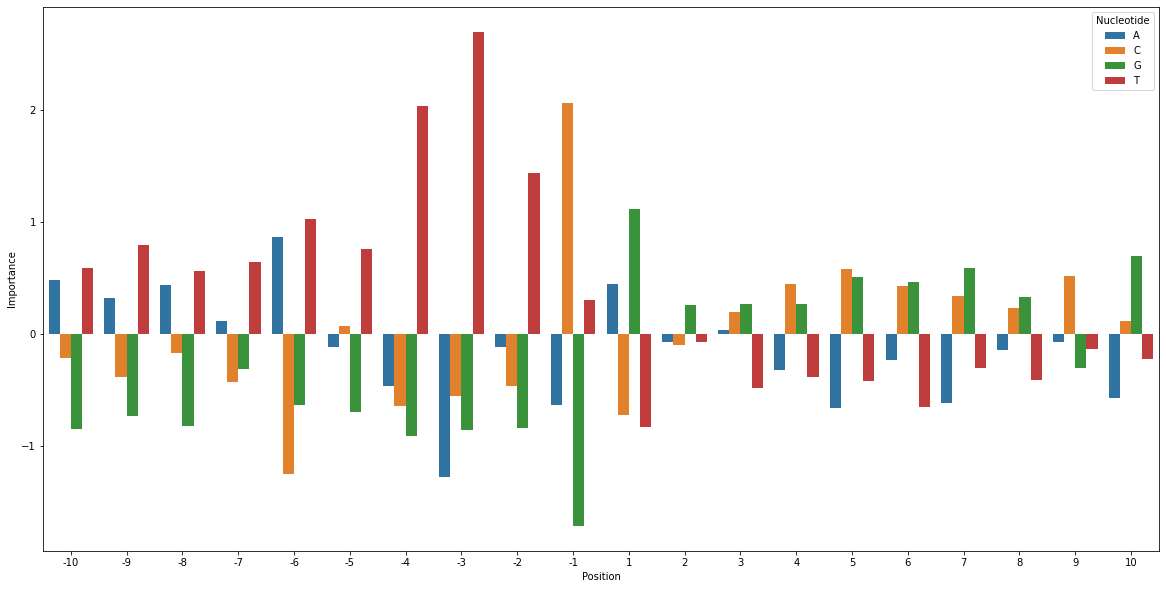

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_nuc(x):
    return(x.str.split("_")[1])

def get_position(x):
    if x.str.split("_")[0] == "A": return 0
    if x.str.split("_")[0] == "G": return 0
    return(int(x.str.split("_")[0]))

###Start code here

data = pd.DataFrame({"Position" : F_importances["feature_name"].str.split("_", expand=True)[0],
                    "Nucleotide" : F_importances["feature_name"].str.split("_", expand=True)[1],
                    "Importance" : F_importances["importance"]})
plt.figure(figsize=(20, 10))
ax = sns.barplot(data=data,
    x="Position", 
    y="Importance", 
    hue="Nucleotide"
    )

#End code here